In [1]:
import os
import torchvision
from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim
import time
import os.path
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import copy

In [2]:
print("Torch Version",torch.__version__)

Torch Version 0.4.1


In [3]:
main_dir = "data/augmented"
data_dir = os.path.join(main_dir, "Wheat")
train_dir = os.path.join(data_dir, "train")
valid_dir = os.path.join(data_dir, "valid")
test_dir = os.path.join(data_dir, "test")

In [4]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(valid_dir):
    print (root, len(files))
    
print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data/augmented\Wheat\train 0
data/augmented\Wheat\train\loged 3360
data/augmented\Wheat\train\Nonloged 6240
******************************
data/augmented\Wheat\valid 0
data/augmented\Wheat\valid\loged 848
data/augmented\Wheat\valid\Nonloged 1552
******************************
data/augmented\Wheat\test 0
data/augmented\Wheat\test\loged 64
data/augmented\Wheat\test\Nonloged 122


In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

In [6]:
dataset_mean = [0.485, 0.456, 0.406]
dataset_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
#                                       transforms.RandomHorizontalFlip(),
#                                       transforms.RandomRotation(10, expand=True),
#                                       transforms.CenterCrop(224),
                                      transforms.Grayscale(num_output_channels=3),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=dataset_mean,
                                                            std=dataset_std)])

test_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.Grayscale(num_output_channels=3),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=dataset_mean,
                                                            std=dataset_std)])

train_dataset =  torchvision.datasets.ImageFolder(train_dir,
                                                transform=train_transform)

valid_dataset =  torchvision.datasets.ImageFolder(train_dir,
                                                transform=train_transform)

test_dataset =  torchvision.datasets.ImageFolder(test_dir,
                                                transform=test_transform)

batch_size = 32
dataloaders = {}

dataloaders["train"] = torch.utils.data.DataLoader(train_dataset,
                                                   shuffle=True,
                                                   batch_size=batch_size,
                                                   num_workers=1)

dataloaders["valid"] = torch.utils.data.DataLoader(valid_dataset,
                                                   shuffle=True,
                                                   batch_size=batch_size,
                                                   num_workers=1)

dataloaders["test"] = torch.utils.data.DataLoader(test_dataset,
                                                  shuffle=True,
                                                  batch_size=batch_size,
                                                  num_workers=1)

dataset_sizes = {"train": len(train_dataset), 
                 "valid":len(valid_dataset),
                 "test":len(test_dataset)}

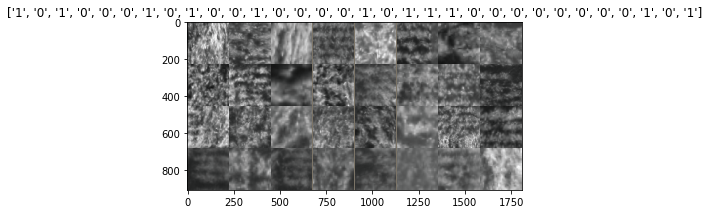

In [7]:
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[str(x.item()) for x in classes])

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
print(dataset_sizes)
print(device)

{'valid': 9600, 'train': 9600, 'test': 186}
cuda:0


In [11]:
num_classes = 2

model = torchvision.models.resnet101(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)    

fc = torch.nn.Sequential(
    nn.Dropout(p=0.15),
    nn.LeakyReLU(0.1),
    nn.Linear(num_features, 2))

model.fc = fc
model = model.to(device)

criterion = nn.CrossEntropyLoss()
#Optimize only the classifier
optimizer = torch.optim.SGD(list(filter(lambda p: p.requires_grad, model.parameters())), lr=0.001, momentum=0.9)

In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 20)
#         print(".", end="", sep="")
        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
#                 scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
#                 print(".", end="")
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [13]:
if torch.cuda.is_available():
    print("Cuda is available.")
    model = torch.nn.DataParallel(model).cuda();

model = train_model(model, criterion, optimizer, scheduler=None, num_epochs=50)

Cuda is available.
Epoch 0/49
--------------------
train Loss: 0.4207 Acc: 0.8091
valid Loss: 0.3631 Acc: 0.8438

Epoch 1/49
--------------------
train Loss: 0.3879 Acc: 0.8305
valid Loss: 0.3460 Acc: 0.8558

Epoch 2/49
--------------------
train Loss: 0.3847 Acc: 0.8343
valid Loss: 0.3429 Acc: 0.8555

Epoch 3/49
--------------------
train Loss: 0.3819 Acc: 0.8355
valid Loss: 0.3422 Acc: 0.8535

Epoch 4/49
--------------------
train Loss: 0.3782 Acc: 0.8363
valid Loss: 0.3458 Acc: 0.8507

Epoch 5/49
--------------------
train Loss: 0.3863 Acc: 0.8334
valid Loss: 0.3652 Acc: 0.8367

Epoch 6/49
--------------------
train Loss: 0.3734 Acc: 0.8357
valid Loss: 0.3631 Acc: 0.8377

Epoch 7/49
--------------------
train Loss: 0.3756 Acc: 0.8378
valid Loss: 0.3400 Acc: 0.8544

Epoch 8/49
--------------------
train Loss: 0.3843 Acc: 0.8358
valid Loss: 0.3390 Acc: 0.8575

Epoch 9/49
--------------------
train Loss: 0.3802 Acc: 0.8355
valid Loss: 0.3407 Acc: 0.8558

Epoch 10/49
-------------------

In [ ]:
torch.save(model.state_dict(), "models/11.wheat_resnet101_augmented.pth")

In [14]:
correct = 0
total = 0
loss = 0
y_pred = []
y_true = []

with torch.no_grad():
    for data in dataloaders["test"]:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        test_loss = criterion(outputs, labels)
        
        y_pred += predicted.to("cpu").detach().numpy().tolist()
        y_true += labels.to("cpu").detach().numpy().tolist()
        
print('Test accuracy: {:.4f}' .format( 100 * correct / total))
print('Test Loss: %.4f'%(test_loss))

Test accuracy: 89.2473
Test Loss: 0.2693


Confusion Matrix
[[116   6]
 [ 14  50]]


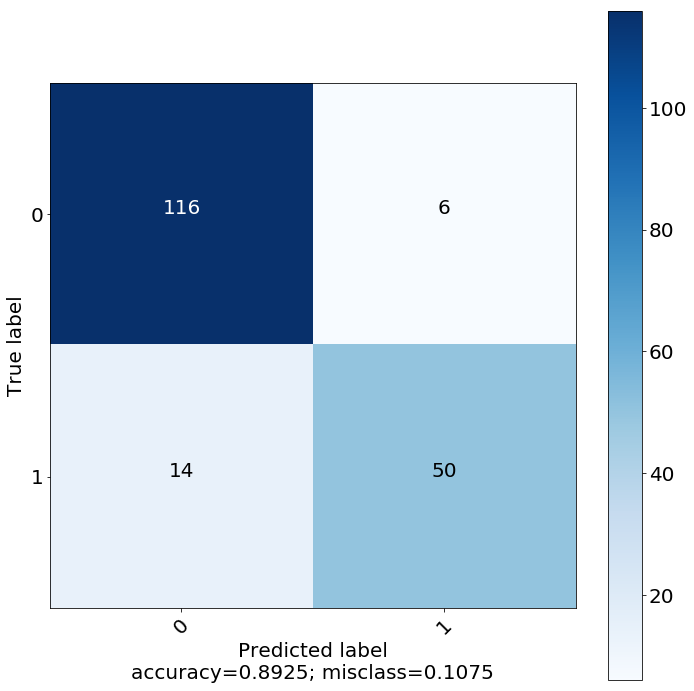

In [15]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)

   
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 
plt.figure(figsize=(10,10))

labels = ['0', '1']

plot_confusion_matrix(cm, classes=labels,
                      title='Confusion Matrix')

In [16]:
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[116   6]
 [ 14  50]]


In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
classnames=[]
for classname in dataloaders["test"]:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_true, y_pred) 
print(confusion_mtx)
target_names = classnames
# print(classification_report(y_true, y_pred, target_names=target_names))
print(classification_report(y_true, y_pred))

[[116   6]
 [ 14  50]]
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       122
           1       0.89      0.78      0.83        64

   micro avg       0.89      0.89      0.89       186
   macro avg       0.89      0.87      0.88       186
weighted avg       0.89      0.89      0.89       186



In [18]:
total=sum(sum(cm))

accuracy = (cm[0,0]+cm[1,1]) / total
print ('Accuracy : ', accuracy*100)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Accuracy :  89.24731182795699
Sensitivity :  89.23076923076924
Specificity :  89.28571428571429


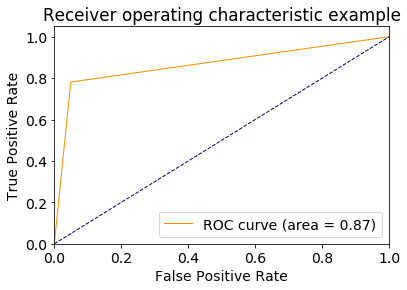

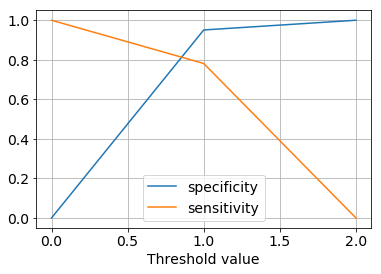

In [19]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 14})

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt

plt.figure()
lw = 1
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#plotting sensitivity and specificity
plt.figure()
plt.plot(thresholds, 1-fpr, label = 'specificity')
plt.plot(thresholds, tpr, label = 'sensitivity')
plt.legend()
plt.grid()
plt.xlabel('Threshold value')
plt.show()

In [20]:
# To view which layers are freeze and which layers are not freezed:
for name, child in model.named_children():
    for name_2, params in child.named_parameters():
        print(name_2, params.requires_grad)

conv1.weight False
bn1.weight False
bn1.bias False
layer1.0.conv1.weight False
layer1.0.bn1.weight False
layer1.0.bn1.bias False
layer1.0.conv2.weight False
layer1.0.bn2.weight False
layer1.0.bn2.bias False
layer1.0.conv3.weight False
layer1.0.bn3.weight False
layer1.0.bn3.bias False
layer1.0.downsample.0.weight False
layer1.0.downsample.1.weight False
layer1.0.downsample.1.bias False
layer1.1.conv1.weight False
layer1.1.bn1.weight False
layer1.1.bn1.bias False
layer1.1.conv2.weight False
layer1.1.bn2.weight False
layer1.1.bn2.bias False
layer1.1.conv3.weight False
layer1.1.bn3.weight False
layer1.1.bn3.bias False
layer1.2.conv1.weight False
layer1.2.bn1.weight False
layer1.2.bn1.bias False
layer1.2.conv2.weight False
layer1.2.bn2.weight False
layer1.2.bn2.bias False
layer1.2.conv3.weight False
layer1.2.bn3.weight False
layer1.2.bn3.bias False
layer2.0.conv1.weight False
layer2.0.bn1.weight False
layer2.0.bn1.bias False
layer2.0.conv2.weight False
layer2.0.bn2.weight False
layer2.0.bn2

layer4.2.bn2.weight False
layer4.2.bn2.bias False
layer4.2.conv3.weight False
layer4.2.bn3.weight False
layer4.2.bn3.bias False
fc.2.weight True
fc.2.bias True
